In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

x = torch.rand(5, 3)
print(x)

Using device: cuda
tensor([[0.6646, 0.1503, 0.4930],
        [0.8558, 0.9184, 0.4810],
        [0.1120, 0.1966, 0.8091],
        [0.7176, 0.6952, 0.7466],
        [0.0409, 0.1166, 0.5442]])


In [5]:


class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Calculate the number of hidden layers based on the provided hidden_size
        self.num_hidden_layers = max(
            0, int(math.log2(self.hidden_size)) - 4
        )  # Subtract 2

        # Dynamically create Linear layers and assign them to attributes
        for layer in range(self.num_hidden_layers + 1):
            in_features = self.hidden_size // (2**layer) if layer > 0 else input_size
            out_features = (
                self.hidden_size // (2 ** (layer + 1))
                if layer < self.num_hidden_layers
                else self.output_size
            )
            setattr(self, f"fc{layer+1}", nn.Linear(in_features, out_features))

        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in range(1, self.num_hidden_layers + 1):
            x = self.relu(getattr(self, f"fc{layer}")(x))
        return getattr(self, f"fc{self.num_hidden_layers + 1}")(x)


# Generate random sample data
np.random.seed(42)
num_samples = 100000
X = np.random.rand(num_samples, 2).astype(np.float32)
y = (X[:, 0] * X[:, 1]).reshape(-1, 1).astype(np.float32)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)
X_val_tensor = torch.tensor(X_val, device=device)
y_val_tensor = torch.tensor(y_val, device=device)


# Create an instance of the model and move it to GPU if available
model = NNModel(2, 128, 1).to(device)

# Attempt to load the model parameters from a file
try:
    model.load_state_dict(torch.load("model.pth"))

    print("Model loaded successfully.")
except FileNotFoundError:
    print("Model file not found.")

train = True
if train:
    # Training loop
    num_epochs = 1000

    criterion = nn.MSELoss()  # Use Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Calculate validation loss
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item()}"
    )

    print("Training finished!")

    # Save the trained model
    torch.save(model.state_dict(), "model.pth")

Model loaded successfully.
Epoch [1000/1000], Train Loss: 0.0000, Val Loss: 5.003393198421691e-06
Training finished!


Model reloaded successfully.
Diff: -0.0019
Diff: -0.0041
Diff: -0.0010
Diff: 0.0011
Diff: -0.0009


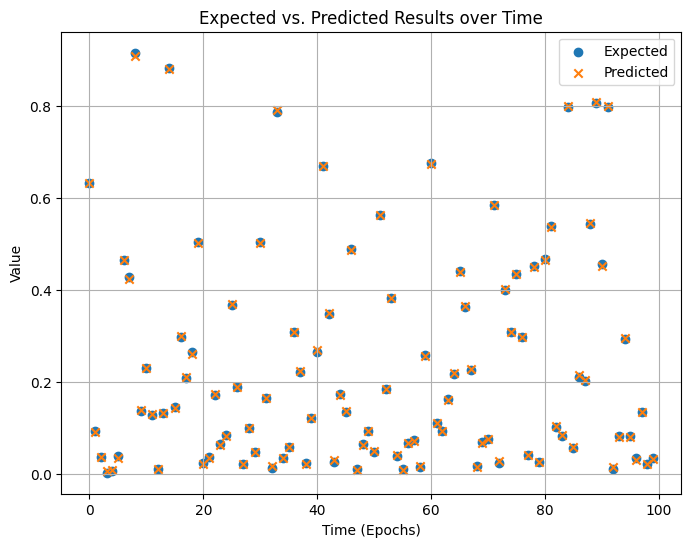

In [7]:
# Attempt to load the model parameters from a file
try:
    model.load_state_dict(torch.load("model.pth"))
    print("Model reloaded successfully.")
except FileNotFoundError:
    print("Model file not found.")

# Generate a new test dataset
X_test = np.random.rand(100, 2).astype(np.float32)
y_test = X_test.prod(axis=1)

# Convert the test data to PyTorch tensors and move to GPU if available
X_test_tensor = torch.tensor(X_test, device=device)

# Run predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_y = model(X_test_tensor)

# Move predictions and ground truth back to CPU for plotting
predicted_y = predicted_y.cpu().numpy()

# Print expected and predicted results along with their corresponding multipliers
for i in range(len(X_test) - 5, len(X_test)):
    multiplier1, multiplier2 = X_test[i]
    expected_result = y_test[i]
    predicted_result = predicted_y[i]
    print(f"Diff: {float(predicted_result - expected_result):.4f}")


# Create a plot with time (epochs) on the x-axis and both expected and predicted values as individual balls
plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, label="Expected", marker="o")
plt.scatter(range(len(X_test)), predicted_y, label="Predicted", marker="x")
plt.xlabel("Time (Epochs)")
plt.ylabel("Value")
plt.title("Expected vs. Predicted Results over Time")
plt.grid(True)
plt.legend()
plt.show()